# Happiness Data Analysis
## Dominic Scerbo (ybt7qf) 

## Purpose: 
This notebook is used to address the question "What factors have the strongest correlation with the happiness ranking". We will also utilize a visualization method called a choropleth map in order to gain more context regarding the diversity of the data set we will show the countries that the data pretains to and their respecitve happiness scores.

## Objectives:
- Data Wrangling
- Generate Choropleth Plot
- Evaluate Correlations and Relationships
- Create and Evaluate a Model

## Environment Setup:
A yaml file is provided to create a conda environment to run this notebook.
To create the environment run the following commands.

In [2]:
%conda env create -f ./data/env/environment.yml


Note: you may need to restart the kernel to use updated packages.



CondaValueError: prefix already exists: C:\Users\mkbau\anaconda3\envs\myvirtualenv



In [3]:
%conda activate myvirtualenv


Note: you may need to restart the kernel to use updated packages.


### Read Happiness Data

In [4]:
%matplotlib inline

In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from yellowbrick.regressor import ResidualsPlot

The first step is to use pandas to read in the happiness csv file

In [33]:
df = pd.read_csv('./data/data_all.csv')
df.drop(df.columns[0], axis=1, inplace=True)
print(len(df))
df.head(3)

1230


,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year,Lower Confidence Interval,Upper Confidence Interval,Whisker.high,Whisker.low
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015,NaN,NaN,NaN,NaN
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015,NaN,NaN,NaN,NaN
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015,NaN,NaN,NaN,NaN


### Validate Data Types

Before conducting the analysis of the dataset we will first validate the data types of our variables of interest to ensure they are appropriate for how we intend to use them. The print out shows the numeric and string types we expected are typed appropriately.

In [34]:
df.dtypes

Country                           object
Region                            object
Happiness Rank                     int64
Happiness Score                  float64
Standard Error                   float64
Economy (GDP per Capita)         float64
Family                           float64
Health (Life Expectancy)         float64
Freedom                          float64
Trust (Government Corruption)    float64
Generosity                       float64
Dystopia Residual                float64
Year                               int64
Lower Confidence Interval        float64
Upper Confidence Interval        float64
Whisker.high                     float64
Whisker.low                      float64
dtype: object

### Collect Country Codes 

The first objective of the analysis is to visualize the dataset globally on a world basemap using a choropleth  visualization method meaning the score is characterized by the intensity of the color gradient on the map. To do this we will first obtain Country Codes for the country in order to associate them with another data file that contains the cuntries boundaries (geometries) for the map.

In [35]:
input_countries = df['Country']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, np.nan) for country in input_countries]

df['Country Code'] = codes
df.head(3)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year,Lower Confidence Interval,Upper Confidence Interval,Whisker.high,Whisker.low,Country Code
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015,NaN,NaN,NaN,NaN,CHE
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015,NaN,NaN,NaN,NaN,ISL
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015,NaN,NaN,NaN,NaN,DNK


### Read Country Shapefile

Now that country code have been added to the dataset we will read in the country geometries which come in a shapefile format. We will use the geopandas package to read in this data which convert the geometry column into a geometry type object.

In [36]:
shapefile = r'C:\Users\mkbau\OneDrive\Documents\GitHub\ds5100-group2\data\ne_10m_admin_0_countries\ne_10m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('EPSG:4326')
print(len(gdf))
gdf.head(3)

258


,ADM0_A3,geometry
0,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."


### Validate Shapefile Data Types

The geometries with with their respective country code have been loaded. We will first validate the data types, noting that we want to ensure the geoemtry column is in fact a geometry data type for plotting purposes.

In [37]:
gdf.dtypes

ADM0_A3       object
geometry    geometry
dtype: object

### Run Unit Test

In order to further valdate the data we an create a script to run a unittest to compare the data type of the geometry field with a test dataframe that has been hardcoded to have a geometry type column. Using the write file magic command we can create the python script from the notebook and execute it from this notebook as well.

In [38]:
%%writefile unittests.py

import os
import unittest
import geopandas as gpd

class GDFTest(unittest.TestCase):
   
    def test_for_geometry(self):
        """
        Unit test to check if geopandas dataframe geometry 
        column is in fact a geopandas geometry data dtype type.

        Returns
        -------
        None.

        """
        
        fp = os.path.join(os.path.dirname(__file__), r'data\ne_10m_admin_0_countries\ne_10m_admin_0_countries.shp')
        test_gdf = gpd.read_file(fp)[['geometry']].to_crs('EPSG:4326')
        
        sample_gdf = gpd.GeoDataFrame({'geometry': []}, crs="EPSG:4326")
        self.assertEqual(test_gdf['geometry'].dtype, sample_gdf['geometry'].dtype)
        
if __name__ == '__main__':
    unittest.main()

Overwriting unittests.py


In [39]:
!python unittests.py

.
----------------------------------------------------------------------
Ran 1 test in 0.248s

OK


### Merge Happiness Data and Shapefile

We can see that the test passed. Therefore, we will now merge the Happiness data and the country shapefile. By merging the data we can work with one object for our efforts. To merge data we need to supply a key and a method. The key that we will use is the Country Code which we denote as Country Code in the Happiness dataframe and ADMO_A3 in the shapefile. We use the left method to keep all of the attribute from the happiness dataset and also not drop the countries that aren't captured in one dataset but present in the other.

In [40]:
merged = gdf.merge(df, left_on='ADM0_A3', right_on='Country Code', how='left')
merged.head(3)

,ADM0_A3,geometry,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year,Lower Confidence Interval,Upper Confidence Interval,Whisker.high,Whisker.low,Country Code
0,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",Indonesia,Southeastern Asia,74.0,5.399,0.02596,0.828270,1.087080,0.637930,0.466110,0.000000,0.515350,1.863990,2015.0,NaN,NaN,NaN,NaN,IDN
1,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",Indonesia,Southeastern Asia,79.0,5.314,NaN,0.951040,0.876250,0.493740,0.392370,0.003220,0.565210,2.031710,2016.0,5.237,5.391,NaN,NaN,IDN
2,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",Indonesia,Southeast Asia,81.0,5.262,NaN,0.995539,1.274445,0.492346,0.443323,0.015317,0.611705,1.429477,2017.0,NaN,NaN,5.352889,5.171112,IDN


In [ ]:
merged.to_csv('./data/data_all_geo.csv')

### Aggregate Happiness Data

Since we have multiple years for the happiness data we will aggregate the data. The grouping will be based on the country column and we will get the mean. For spatial data, we will need to use the dissolve function to aggregate geometric features.

In [41]:
merged_grouped = merged.dissolve(by = 'ADM0_A3', aggfunc='mean', as_index=False)

We will also check the data types to validate the geometry field type was conserved after the dissolve method was used.

In [11]:
merged_grouped.dtypes

ADM0_A3                            object
geometry                         geometry
Happiness Rank                    float64
Happiness Score                   float64
Standard Error                    float64
Economy (GDP per Capita)          float64
Family                            float64
Health (Life Expectancy)          float64
Freedom                           float64
Trust (Government Corruption)     float64
Generosity                        float64
Dystopia Residual                 float64
Year                              float64
Lower Confidence Interval         float64
Upper Confidence Interval         float64
Whisker.high                      float64
Whisker.low                       float64
dtype: object

### Assess Clean Data

The dissolve method worked as intended. Now we will note that in some cases one can see that we do not have the Happiness Score for some countries. We will leave the NaN value and custumize the visualization to show where that missing data is.

In [12]:
merged_grouped[['Happiness Score', 'geometry', 'ADM0_A3']].head(3)

,Happiness Score,geometry,ADM0_A3
0,NaN,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",ABW
1,3.132237,"POLYGON ((74.54814 37.00164, 74.54421 36.99402...",AFG
2,3.872250,"MULTIPOLYGON (((11.73851 -16.70582, 11.71579 -...",AGO


### Build Choropleth Map

Now that the data wrangling and cleaning processes are complete we can create the choropleth map to visualize the data.

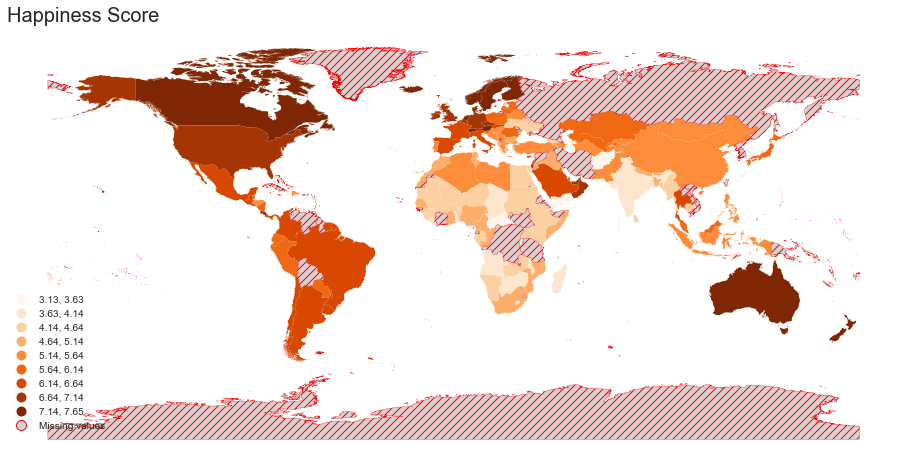

In [13]:
colors = 9
cmap = 'Oranges'
figsize = (16, 10)
val = 'Happiness Score'
title = '{}'.format(val)
description = ''''''.strip()

ax = merged_grouped.plot(column=val, 
                 cmap=cmap, 
                 figsize=figsize, 
                 scheme='equal_interval', 
                 k=colors, 
                 legend=True,
                 missing_kwds={
                    "color": "lightgrey",
                    "edgecolor": "red",
                    "hatch": "///",
                    "label": "Missing values"})

ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
ax.annotate(description, xy=(0.1, 0.1), size=12, xycoords='figure fraction')

ax.set_axis_off()
ax.get_legend().set_bbox_to_anchor((.12, .4))

### Analyze Choropleth Results

We can now reference this map to quickly note which countries are and are not contained on the data, which is useful for quickly resolving any missing data or faciliating discussion about the data. One can conlude there is fair global coverage showing little bias in the collected data

Using this visualization method we can see that North American, South American, and European countries as well as Austrialia have higher happiness score, while African, Asian, and some middle eastern countries have lower happiness scores. Furthermore, we see that Antartica Greenland, Russia, and several other countries is various regions do not have any data collected. 

This visualization has provided us with an intutative way to quickly analyze the data that was collected. Next we will look more at the data in greater detail to determine what factors amoungst there nations have the strongest correlation to the happiness score. We will built off of the merged_grouped dataframe.

### Clean Dataset

Since the dataset contains NA for countries that were not included in the happiness dataset we will need to consider that there are NA values in the dataframe so lets drop those to continue this analysis. 

In [68]:
merged_grouped_clean = merged_grouped.dropna()
merged_grouped_clean.isna().any()

ADM0_A3                          False
geometry                         False
Happiness Rank                   False
Happiness Score                  False
Standard Error                   False
Economy (GDP per Capita)         False
Family                           False
Health (Life Expectancy)         False
Freedom                          False
Trust (Government Corruption)    False
Generosity                       False
Dystopia Residual                False
Year                             False
Lower Confidence Interval        False
Upper Confidence Interval        False
Whisker.high                     False
Whisker.low                      False
dtype: bool

### Filter Unneeded Fields

Some fields in the dataset are also intuatively not good predictors or will have meaningful relationship to happiness score, so we will also consider a subset of the features in this analysis and drop the rest.

In [69]:
features = ["Happiness Rank", 
            "Happiness Score", 
            "Standard Error", 
            "Economy (GDP per Capita)", 
            "Family",
            "Health (Life Expectancy)", 
            "Freedom",
            "Trust (Government Corruption)", 
            "Generosity", 
            "Dystopia Residual"]
merged_grouped_clean = merged_grouped_clean[features]
merged_grouped_clean.columns

Index(['Happiness Rank', 'Happiness Score', 'Standard Error',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity',
       'Dystopia Residual'],
      dtype='object')

### Gather Correlation Stats

The first approach to understand the correlations in the dataset is to gather the correlation coefficients to contextually assess the correlation. We can easily find highly correlated values by adding a color map to the matrix of values. Mild color denote a weak correlation.

In [70]:
corr = merged_grouped_clean.corr().style.background_gradient(cmap='coolwarm')
corr

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Happiness Rank,1.000000,-0.993292,0.163901,-0.839824,-0.787060,-0.827044,-0.632148,-0.464224,-0.142263,-0.486191
Happiness Score,-0.993292,1.000000,-0.188292,0.836646,0.791992,0.824236,0.641517,0.489399,0.167562,0.488722
Standard Error,0.163901,-0.188292,1.000000,-0.215458,-0.117939,-0.222405,-0.160793,-0.317853,-0.084794,0.056269
Economy (GDP per Capita),-0.839824,0.836646,-0.215458,1.000000,0.757015,0.852064,0.464885,0.390598,-0.029725,0.072517
Family,-0.787060,0.791992,-0.117939,0.757015,1.000000,0.694717,0.484262,0.287282,0.107520,0.098053
Health (Life Expectancy),-0.827044,0.824236,-0.222405,0.852064,0.694717,1.000000,0.506747,0.373610,0.000119,0.121653
Freedom,-0.632148,0.641517,-0.160793,0.464885,0.484262,0.506747,1.000000,0.497575,0.348616,0.108247
Trust (Government Corruption),-0.464224,0.489399,-0.317853,0.390598,0.287282,0.373610,0.497575,1.000000,0.282316,0.034081
Generosity,-0.142263,0.167562,-0.084794,-0.029725,0.107520,0.000119,0.348616,0.282316,1.000000,-0.045667
Dystopia Residual,-0.486191,0.488722,0.056269,0.072517,0.098053,0.121653,0.108247,0.034081,-0.045667,1.000000


We can see that Econ, Family, and Health are strongly correlated to the happiness score. addtionally, one can see that there is in fact a strong correlation between family, health, and econ 

### Validate Relationships

Now that we have an idea of the most strongly correlated values let's do a scatter plot to validate the relationship.

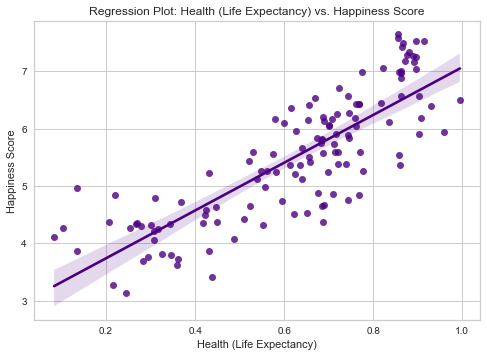

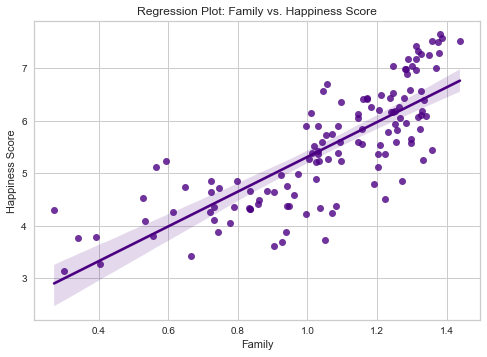

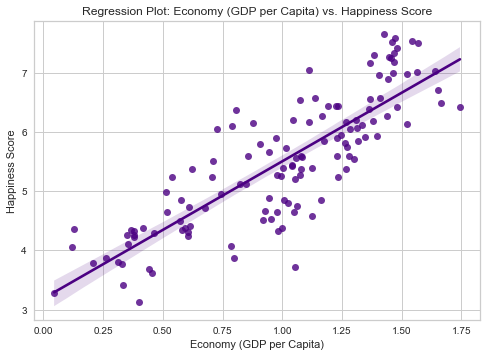

In [71]:
correlated_vars = ['Health (Life Expectancy)', 'Family', 'Economy (GDP per Capita)']
for var in correlated_vars:
    plt.figure()
    ax = sns.regplot(x=merged_grouped_clean[var], y=merged_grouped_clean["Happiness Score"], color='indigo')
    ax.set_title('Regression Plot: ' + var + ' vs. ' + "Happiness Score")

The variable that we noted as strongly correlated do in fact have a positve linear relationship to the happiness score.

Since we see that there is a linear relationship between these variables we can now utilties them to determine if they are good predictors of happiness score.

Using the sklearn package we can quickly create a multiple linear regression model for the stringly variables we discovered to the happiness score.

### Set Predictors and Response Variables

In [72]:
df = merged_grouped_clean

In [73]:
pred = ['Health (Life Expectancy)', 'Family', 'Economy (GDP per Capita)']
resp = ['Happiness Score']

In [74]:
keep_cols = pred + resp
df = df[keep_cols]
df = df.dropna()
print(df.columns)

Index(['Health (Life Expectancy)', 'Family', 'Economy (GDP per Capita)',
       'Happiness Score'],
      dtype='object')


### Split Train and Test Data

In [75]:
X = df[pred]
y = df[resp]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

### Feature Scaling

In [77]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Formating

In [78]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [79]:
print('Train Data Shape X:{} y:{}'.format(X_train.shape, y_train.shape))
print('Test Data Shape X:{} y:{}'.format(X_test.shape, y_test.shape))

Train Data Shape X:(103, 3) y:(103,)
Test Data Shape X:(26, 3) y:(26,)


### Fit Model 

In [80]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [81]:
print("Intercept: ", mlr.intercept_)
print("Coefficients:")
list(zip(X, mlr.coef_))

Intercept:  5.478116486516679
Coefficients:


[('Health (Life Expectancy)', 0.4235911436510792),
 ('Family', 0.4300857764663586),
 ('Economy (GDP per Capita)', 0.24708981372988795)]

### Prediction of Test Set

In [82]:
y_pred_mlr= mlr.predict(X_test)
print("Prediction for test set: {}".format(y_pred_mlr))

Prediction for test set: [3.15796937 3.47280322 6.90088555 4.60853688 4.14626997 6.73784133
 6.72299128 6.48164671 3.9771345  5.32342054 4.23168077 6.15921242
 6.61105885 4.57079176 5.79881392 5.26525165 6.10000738 5.75760943
 5.53461673 6.61274605 5.84192357 4.6238731  4.35842883 6.78586367
 6.63741928 6.08191014]


### Check Results

In [83]:
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
mlr_diff.head()

,Actual value,Predicted value
0,4.298625,3.157969
1,4.268175,3.472803
2,6.493513,6.900886
3,5.116725,4.608537
4,5.232912,4.146270


### Model Evaluation

In [84]:
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('R squared (train): {:.2f}'.format(mlr.score(X_train, y_train)))
print('R squared (test): {:.2f}'.format(mlr.score(X_test, y_test)))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared (train): 0.80
R squared (test): 0.71
Mean Absolute Error: 0.46315634035423636
Mean Square Error: 0.29712944886364284
Root Mean Square Error: 0.5450958162228388


### Validate Model Assumptions

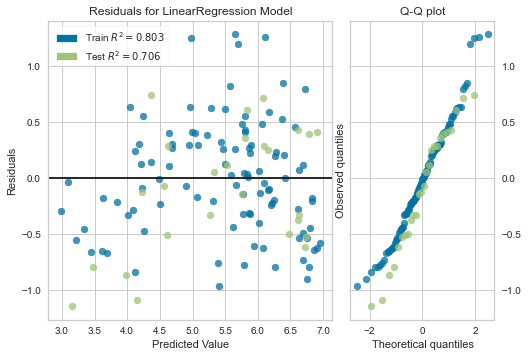

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [85]:
visualizer = ResidualsPlot(mlr, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()  

### Model Results

The residual plot shows that the assumptions for the multiple regression model appear to be satisfied. In
general, the residuals fall in a horizontal band around the mean of 0 and have a constant variance. There
appears to be no curve or pattern, so overall the assumptions appear to be met. The ACF is slightly
significant at lag 1, but this could be due to sampling variation. Since the data is not collected in some
sequence they are unlikely to be correlated. For the QQ plot the points fall close to the diagonal line,
therefore the normality assumption of the errors are met.

The Multiple Linear Regression model has fair performance fitting 79% of the data to the regression model for the training data. However, the test set only achieved 71%. The mean absolute error, mean square error, and the root mean square error for this model are at acceptable ranges.